In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
# Среда для игры Крестики-нолики
class TicTacToe:
    def __init__(self):
        # Изначально пустая доска 3x3
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1  # Игрок 1 - 'X' (1), Игрок -1 - 'O' (-1)

    def reset(self):
        # Сброс доски к начальному состоянию
        self.board.fill(0)
        self.current_player = 1
        return self.board

    def step(self, action):
        # Выполнить действие, обновить доску и проверить конец игры
        if self.board[action] != 0:
            raise ValueError("Invalid action!")
        self.board[action] = self.current_player
        reward, done = self.check_game_over()
        self.current_player *= -1  # Смена игроков
        return self.board, reward, done

    def check_game_over(self):
        # Проверка победы/проигрыша или ничьей
        for i in range(3):
            if abs(sum(self.board[i, :])) == 3 or abs(sum(self.board[:, i])) == 3:
                return 1 * self.current_player, True
        if abs(sum(self.board.diagonal())) == 3 or abs(sum(np.fliplr(self.board).diagonal())) == 3:
            return 1 * self.current_player, True
        return (0, True) if not (self.board == 0).any() else (0, False)

    def available_actions(self):
        # Вернуть доступные действия
        return [(i, j) for i in range(3) for j in range(3) if self.board[i, j] == 0]


In [6]:
# Простой противник
class SimpleAgent:
    def __init__(self, strategy="random"):
        self.strategy = strategy  # Стратегия противника

    def choose_action(self, env):
        actions = env.available_actions()
        if self.strategy == "random":
            return random.choice(actions)  # Случайный выбор действия
        center, corners = (1, 1), [(0, 0), (0, 2), (2, 0), (2, 2)]
        return center if center in actions else random.choice([c for c in corners if c in actions] or actions)

In [8]:
# Агент с Q-обучением и уменьшением epsilon
class QLearningAgent:
    def __init__(self, alpha=0.05, gamma=0.9, epsilon=0.2, epsilon_decay=0.999):
        self.q_table = defaultdict(lambda: np.zeros((3, 3)))  # Q-таблица для хранения значений действий
        self.alpha = alpha  # Скорость обучения
        self.gamma = gamma  # Коэффициент дисконтирования
        self.epsilon = epsilon  # Начальная вероятность исследования
        self.epsilon_decay = epsilon_decay  # Скорость уменьшения epsilon

    def get_state(self, board):
        # Преобразование доски в кортеж для использования в Q-таблице
        return tuple(map(tuple, board))

    def choose_action(self, state, available_actions):
        # Выбор действия с использованием epsilon-жадной стратегии
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(available_actions)  # Исследование (Explore)
        return max(available_actions, key=lambda x: self.q_table[state][x])  # Использование

    def update_q_value(self, state, action, reward, next_state, done):
        # Обновление значения Q (Update Q-value)
        current_q_value = self.q_table[state][action]
        next_max_q_value = np.max(self.q_table[next_state]) if not done else 0
        new_q_value = current_q_value + self.alpha * (reward + self.gamma * next_max_q_value - current_q_value)
        self.q_table[state][action] = new_q_value

    def learn(self, env, opponent, episodes=10000):
        rewards = []  # Список для хранения вознаграждений
        for episode in range(episodes):
            # Уменьшение epsilon каждый эпизод
            self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)
            state, total_reward, done = self.get_state(env.reset()), 0, False

            while not done:
                if env.current_player == 1:
                    available_actions = env.available_actions()
                    action = self.choose_action(state, available_actions)
                    next_board, reward, done = env.step(action)
                    next_state = self.get_state(next_board)
                    self.update_q_value(state, action, reward, next_state, done)
                    state, total_reward = next_state, total_reward + reward
                else:
                    env.step(opponent.choose_action(env))
            rewards.append(total_reward)

        return rewards

In [10]:
# Функция скользящего среднего для сглаживания графика
def moving_average(data, window_size=2000):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

In [12]:
# Значения параметров для тестирования
alphas = [0.01, 0.02, 0.05]
gammas = [0.9, 0.95]
epsilon_decays = [0.995, 0.999, 0.9995]

In [14]:
# Переменная для хранения лучшего результата
best_result = None
best_params = {}

In [16]:
# Инициализация среды и противника
env, opponent = TicTacToe(), SimpleAgent("random")

In [18]:
# Перебор всех комбинаций параметров
for alpha in alphas:
    for gamma in gammas:
        for epsilon_decay in epsilon_decays:
            agent = QLearningAgent(alpha=alpha, gamma=gamma, epsilon=0.2, epsilon_decay=epsilon_decay)
            rewards = agent.learn(env, opponent)
            smoothed_rewards = moving_average(rewards, window_size=2000)

            # Вычисление среднего вознаграждения для сравнения
            avg_reward = np.mean(smoothed_rewards)

            # Сохранение лучшего результата
            if best_result is None or avg_reward > best_result:
                best_result = avg_reward
                best_params = {'alpha': alpha, 'gamma': gamma, 'epsilon_decay': epsilon_decay}

In [19]:
# Показать лучшие параметры и результат
print("Best parameters:", best_params)
print("Best average reward:", best_result)

Best parameters: {'alpha': 0.01, 'gamma': 0.95, 'epsilon_decay': 0.999}
Best average reward: 0.993781527309087


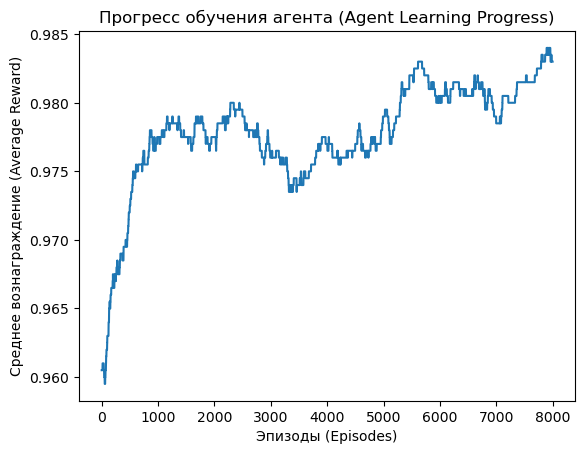

In [22]:
# Построение графика для лучших параметров
agent = QLearningAgent(**best_params, epsilon=0.2)
rewards = agent.learn(env, opponent)
smoothed_rewards = moving_average(rewards, window_size=2000)
plt.plot(smoothed_rewards)
plt.xlabel("Эпизоды (Episodes)")
plt.ylabel("Среднее вознаграждение (Average Reward)")
plt.title("Прогресс обучения агента (Agent Learning Progress)")
plt.show()